# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of service requests generated: 20
{'03612_2024-06-25-17.40': {'60000': [1060, 1060], '71801': [1210, 1210]}, '02731_2024-06-25-13.32': {'60000': [812, 812], '04040': [887, 889], '71500': [962, 964], '71801': [997, 997]}, '03612_2024-06-25-21.27': {'60000': [1287, 1287], '71801': [1437, 1437]}, '02731_2024-06-25-17.27': {'60000': [1047, 1047], '04040': [1122, 1124], '71500': [1197, 1199], '71801': [1232, 1232]}, '02731_2024-06-25-15.44': {'60000': [944, 944], '04040': [1019, 1021], '71500': [1094, 1096], '71801': [1129, 1129]}, '03612_2024-06-25-18.05': {'60000': [1085, 1085], '71801': [1235, 1235]}, '03612_2024-06-25-18.25': {'60000': [1105, 1105], '71801': [1255, 1255]}, '04161_2024-06-25-13.52': {'60000': [832, 832], '70600': [887, 888], '04040': [913, 914], '78400': [957, 959], '71500': [986, 988], '71801': [1024, 1024]}, '03612_2024-06-25-22.57': {'60000': [1377, 1377], '71801': [1527, 1527]}, '03612_2024-06-25-19.12': {'60000': [1152, 1152], '71801': [1302, 1302]}, '03612_2

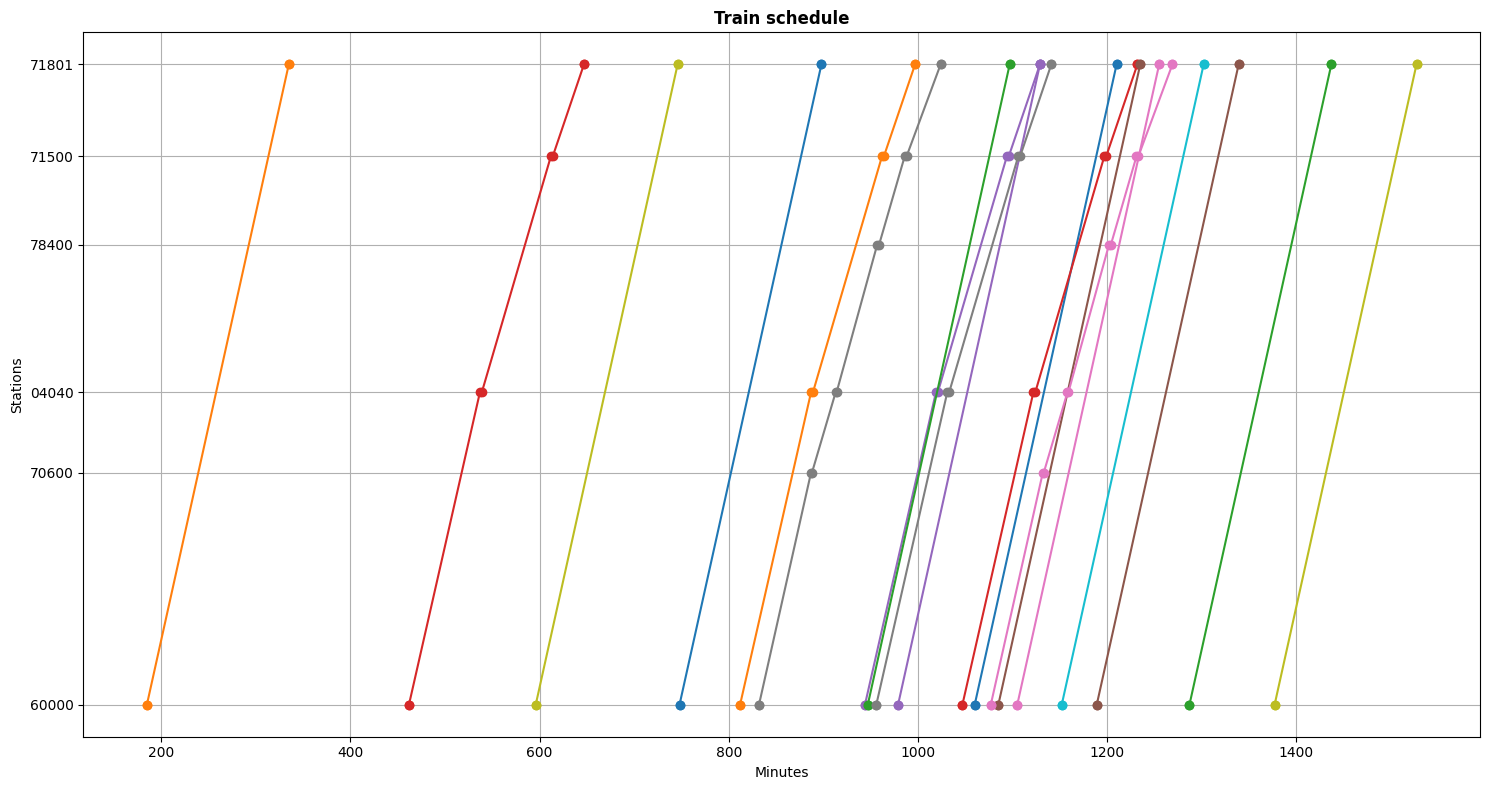

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


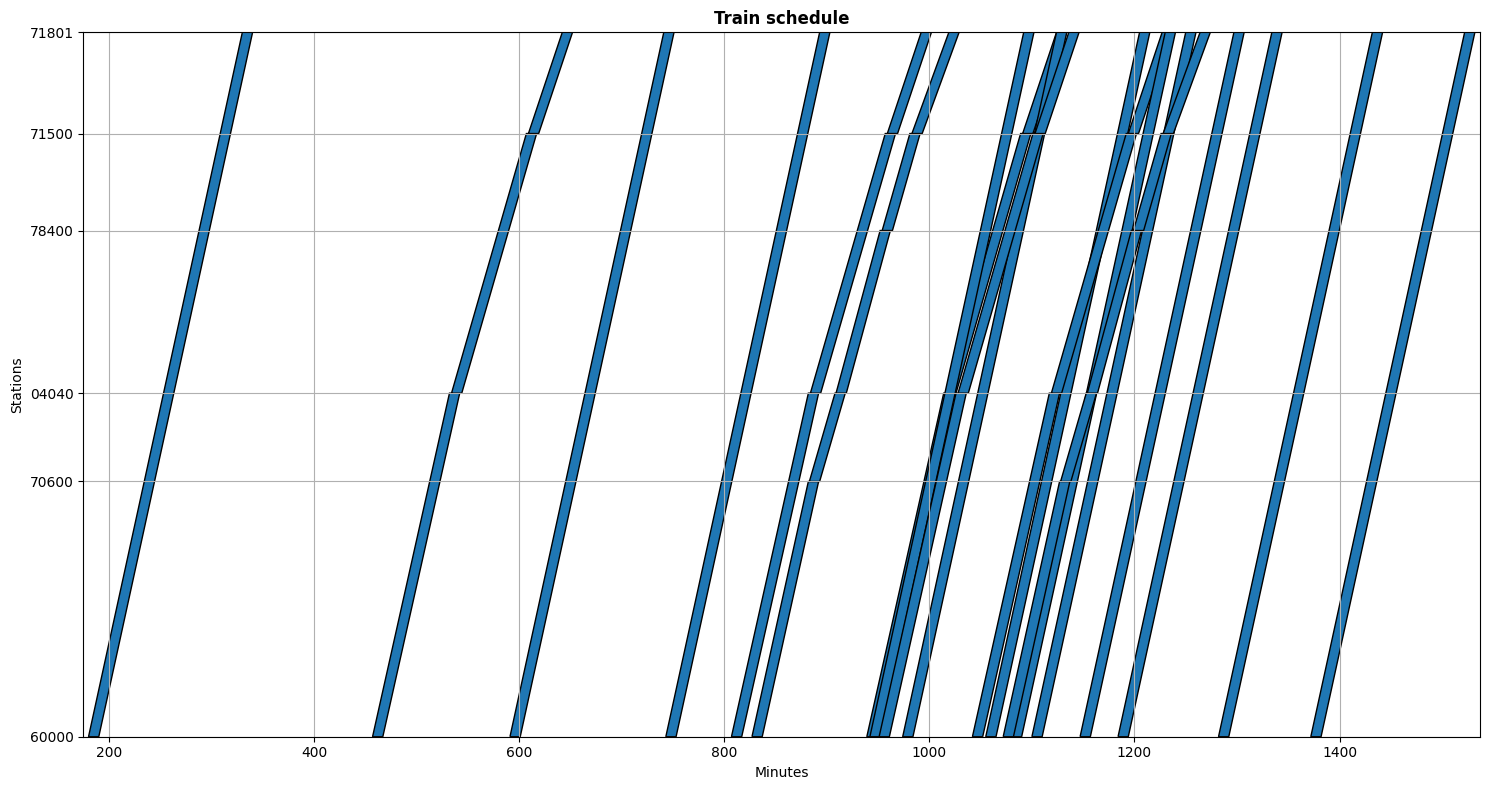

  0%|          | 0/11 [00:00<?, ?it/s]

[[False False False  True False False False False False False False False
  False False False False  True False False]
 [False False False False False False False  True False False False False
  False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False]
 [ True False False False False  True False False False False False False
  False False False False False False False]
 [False False False False False False False False False False False False
   True False  True False False  True False]
 [False False False  True False False False False False False False False
  False False False False  True False False]
 [False False False False False False False False False False False False
  False False False False  True False False]
 [False  True False False False False False False False False False False
  False False False False False False False]
 [False False False False False False False Fals

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.)
6,7.0,2638.110163,6.794646,12.0,4.0,14.0
1,2.0,2588.384783,6.584628,12.0,7.0,31.0
2,3.0,2572.256556,6.685067,12.0,8.0,33.0
5,6.0,2566.524051,6.732226,12.0,7.0,39.0
9,10.0,2562.632253,6.841965,12.0,6.0,37.0
10,11.0,2558.734789,6.789551,12.0,5.0,40.0
0,1.0,2558.461735,6.683961,12.0,5.0,39.0
4,5.0,2547.968858,6.680129,12.0,11.0,35.0
7,8.0,2545.479516,6.859243,12.0,12.0,37.0
8,9.0,2536.136235,6.828621,12.0,6.0,50.0


Global GSA status:
	Total execution time: 74.1356 s.
	Execution Time (by run) - Mean: 6.7396 s. - Std: 0.0889 s.
	Revenue - Mean: 2561.8285 - Std: 33.1321
	Scheduled Trains - Mean: 12.0 - Std: 0.0
	Median solution: Run 11
	Max Revenue: 3888.5 - WARNING!: Scheduling all services could not be feasible


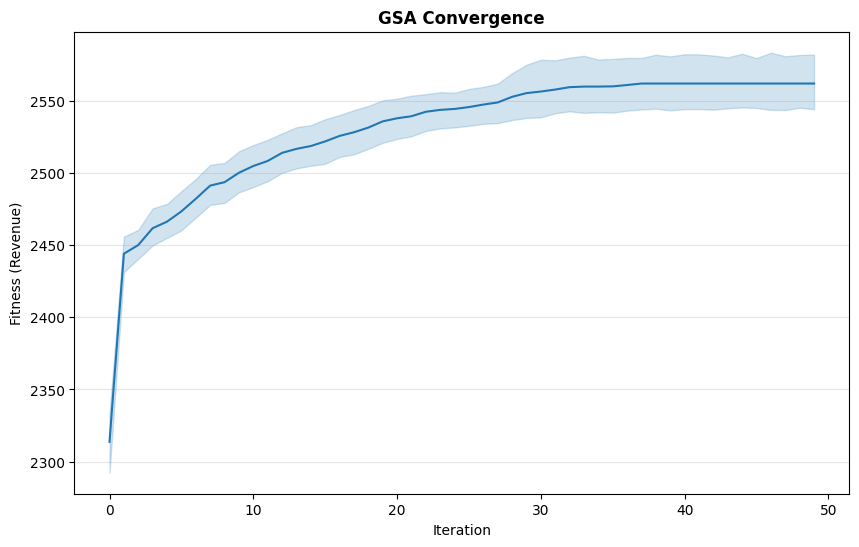

{'03612_2024-06-25-21.27': {'60000': [1287.0, 1287.0], '71801': [1437.0, 1437.0]}, '02731_2024-06-25-17.27': {'60000': [1047.0, 1047.0], '04040': [1122.0, 1124.0], '71500': [1197.0, 1199.0], '71801': [1232.0, 1232.0]}, '04161_2024-06-25-13.52': {'60000': [832.0, 832.0], '70600': [887.0, 889.0], '04040': [914.0, 915.0], '78400': [958.0, 965.0], '71500': [992.0, 995.0], '71801': [1031.0, 1031.0]}, '03612_2024-06-25-22.57': {'60000': [1378.0, 1378.0], '71801': [1528.0, 1528.0]}, '03612_2024-06-25-19.12': {'60000': [1153.0, 1153.0], '71801': [1303.0, 1303.0]}, '03612_2024-06-25-12.28': {'60000': [748.0, 748.0], '71801': [898.0, 898.0]}, '03612_2024-06-25-3.05': {'60000': [186.0, 186.0], '71801': [336.0, 336.0]}, '02731_2024-06-25-7.42': {'60000': [462.0, 462.0], '04040': [537.0, 539.0], '71500': [612.0, 615.0], '71801': [648.0, 648.0]}, '03612_2024-06-25-19.49': {'60000': [1190.0, 1190.0], '71801': [1340.0, 1340.0]}, '04161_2024-06-25-17.57': {'60000': [1077.0, 1077.0], '70600': [1132.0, 1

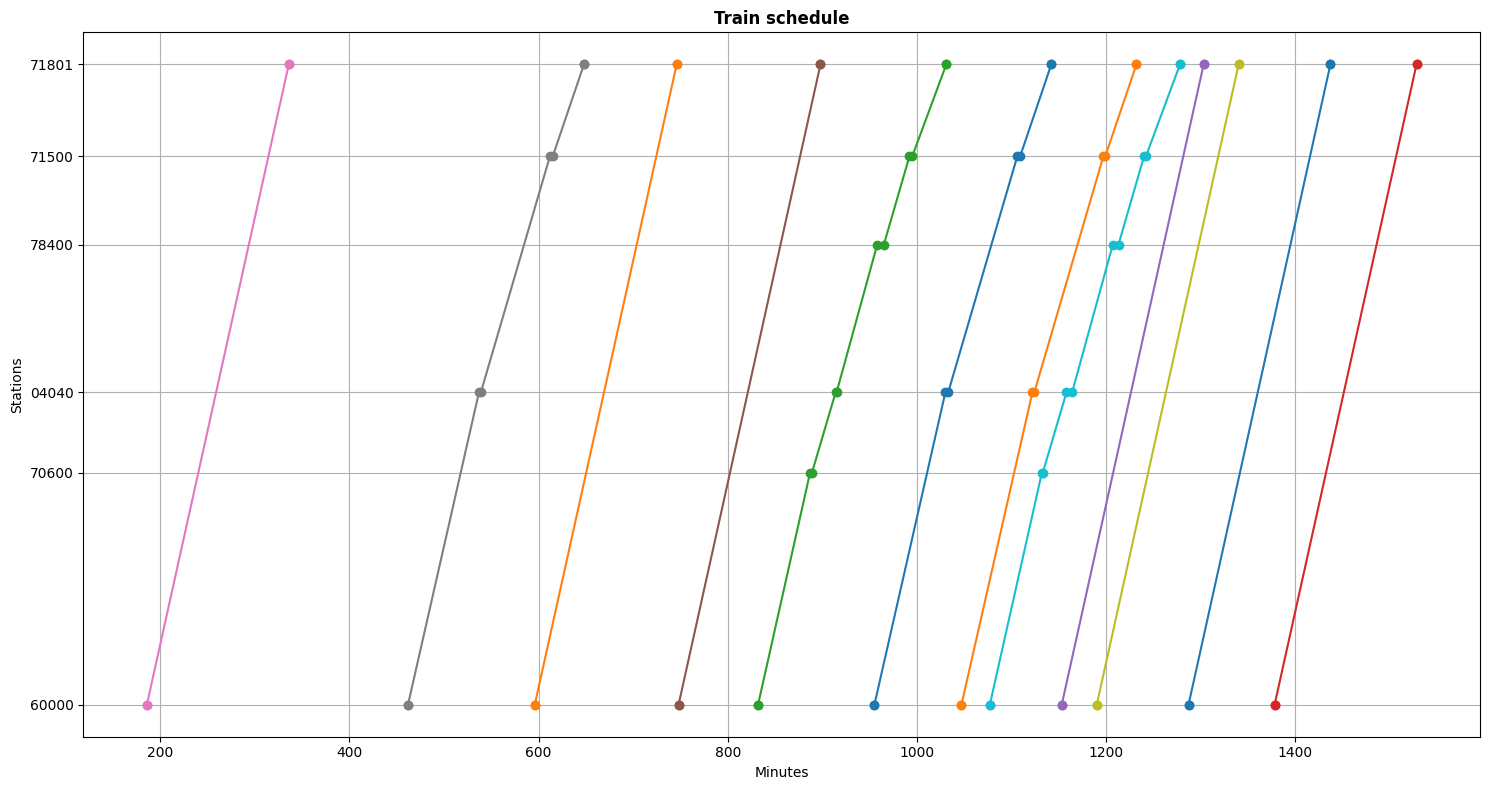

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


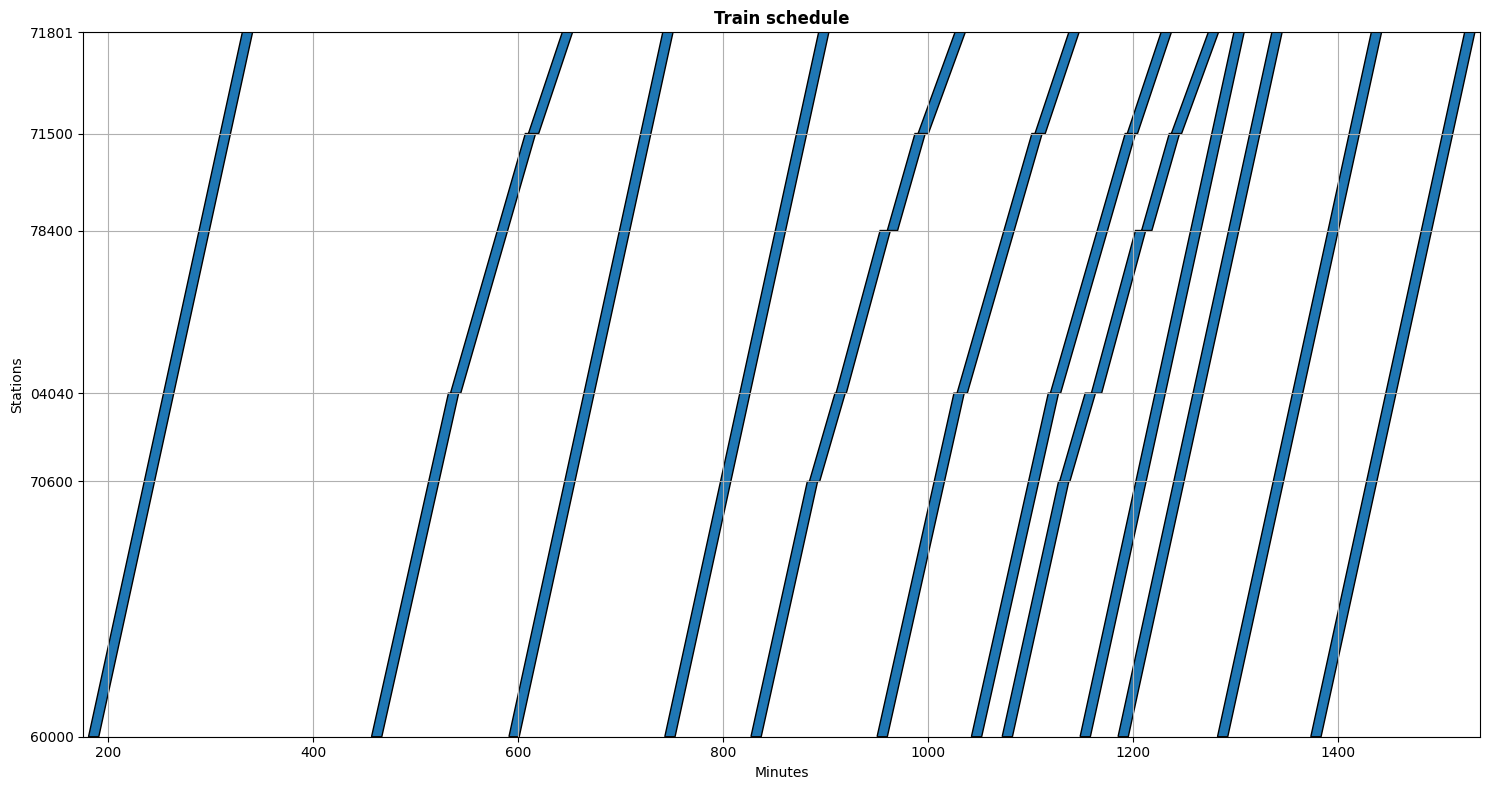

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 4624
	Status: User bought a service which was not the one with the best utility. - Passengers: 2940
	Status: User bought the ticket with best utility. - Passengers: 1279
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4219
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 700 - Percentage: 16.59 %
		Seat: Turista - Passengers: 3519 - Percentage: 83.41 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4219
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Turista - Number of tickets sold: 152
		Date: 2023-06-12
			Seat: Turista - Number of tickets sold: 177
		Date: 2023-06-13
			Seat: Turista - Number of tickets sold: 153
		Date: 2023-06-14
			Seat: Premium - Number of tickets sold: 50
			Seat: Turista - Number of tickets sold: 135
		Date:

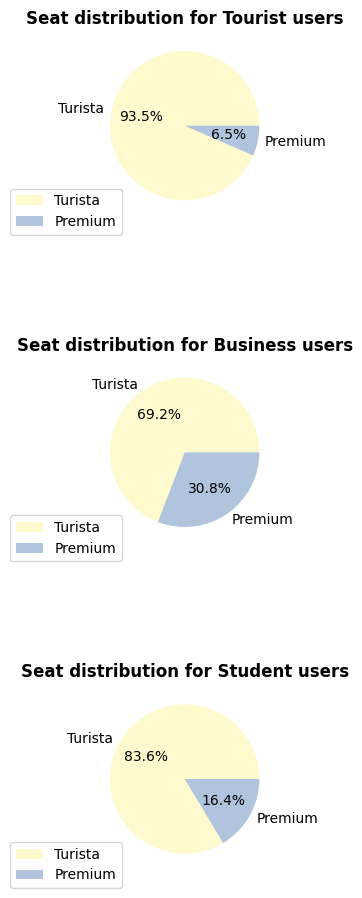

In [42]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path=generator_save_path,
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=f'{robin_save_path}output.yml',
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=11,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [10]:
from robin.demand.entities import Demand

demand = Demand.from_yaml('../configs/demand/demand.yml')

In [11]:
passengers = demand.generate_passengers()

In [12]:
p = passengers[0]

In [19]:
values = [float(rule.split(' ')[-1]) for r, rule in p.user_pattern._rules.items()]
values

[30.0, 40.0, 30.0]

In [44]:
import random

def update_rules(values: list, max_change: int=2):
    for _ in range(len(values)):
        # Set two random indexes
        idx1, idx2 = random.sample(range(len(values)), 2)
        
        # Calculate the amount of change
        cambio = np.round(random.uniform(1, min(max_change, values[idx1], values[idx2])))
        
        # Adjust the values
        values[idx1] -= cambio
        values[idx2] += cambio    
    return values

# Original
original = [30.0, 40.0, 30.0]

updated = update_rules(original.copy())
updated

[29.0, 37.0, 34.0]

100.0


{'03612_2024-06-25-18.25': {'60000': [1104.0, 1104.0], '71801': [1254.0, 1254.0]}, '04161_2024-06-25-17.57': {'60000': [1077.0, 1077.0], '70600': [1132.0, 1133.0], '04040': [1158.0, 1164.0], '78400': [1207.0, 1212.0], '71500': [1239.0, 1242.0], '71801': [1278.0, 1278.0]}}
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0}


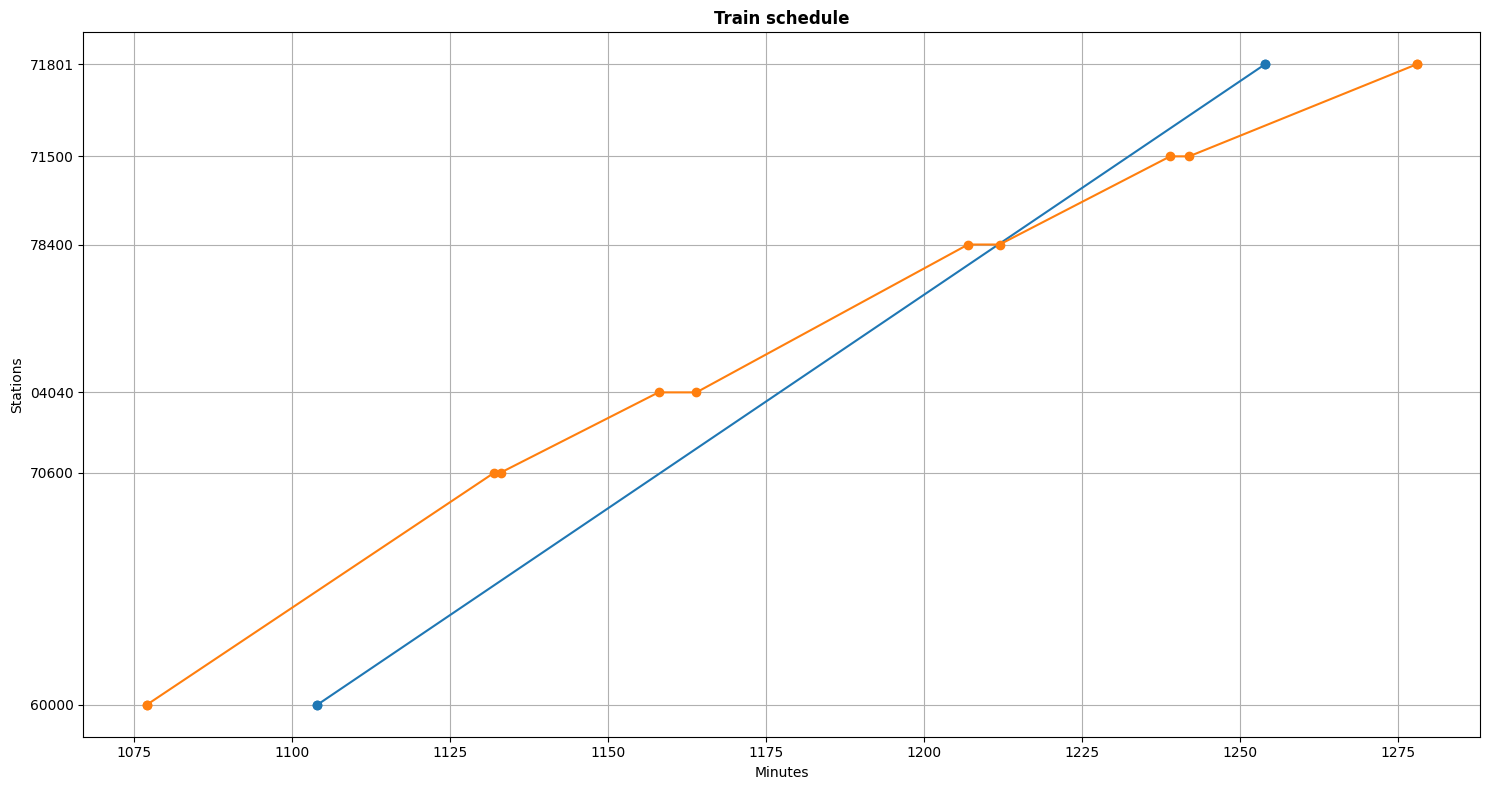

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


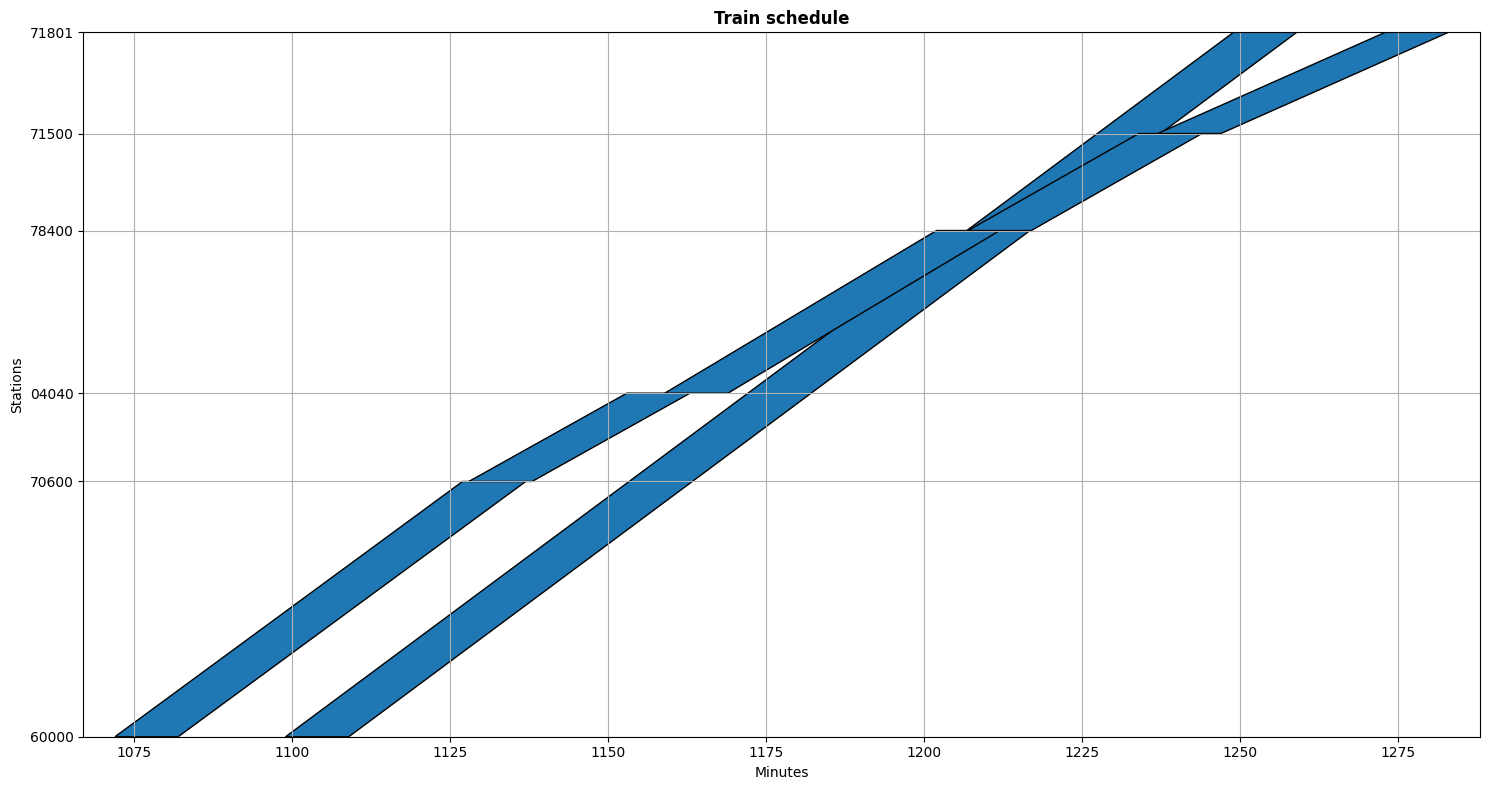

In [33]:
from benchmarks.utils import TrainSchedulePlotter

# Original schedule
"""
schedule = {'03612_2024-06-25-17.40': {'60000': [1060, 1060], '71801': [1210, 1210]}, 
            '02731_2024-06-25-17.27': {'60000': [1047, 1047], '04040': [1122, 1124], '71500': [1197, 1199], '71801': [1232, 1232]},
            '03612_2024-06-25-18.05': {'60000': [1085, 1085], '71801': [1235, 1235]},
            '03612_2024-06-25-18.25': {'60000': [1105, 1105], '71801': [1255, 1255]},
            '03612_2024-06-25-19.12': {'60000': [1152, 1152], '71801': [1302, 1302]},
            '03612_2024-06-25-19.49': {'60000': [1189, 1189], '71801': [1339, 1339]},
            '04161_2024-06-25-17.57': {'60000': [1077, 1077], '70600': [1132, 1133], '04040': [1158, 1159], '78400': [1202, 1204], '71500': [1231, 1233], '71801': [1269, 1269]}}
"""

# GSA Schedule solution
schedule = {'03612_2024-06-25-18.25': {'60000': [1104.0, 1104.0], '71801': [1254.0, 1254.0]},
            '04161_2024-06-25-17.57': {'60000': [1077.0, 1077.0], '70600': [1132.0, 1133.0], '04040': [1158.0, 1164.0], '78400': [1207.0, 1212.0], '71500': [1239.0, 1242.0], '71801': [1278.0, 1278.0]}}

#schedule = dict(sorted(schedule.items(), key=lambda x: tuple(x[1].values())[0]))
print(schedule)
            
line = {'60000': (40.406442, -3.690886),
         '70600': (41.346692, -1.63868),
         '04040': (41.658649, -0.911615),
        '78400': (41.620696, 0.632669),
        '71500': (41.111624, 1.253214),
        '71801': (41.37922, 2.140624)}

schedule_plotter = TrainSchedulePlotter(schedule, line)
print(schedule_plotter.station_positions)
schedule_plotter.plot()
schedule_plotter.plot_security_gaps()

In [34]:
from benchmarks.utils import get_stations_positions

from numpy import ones,vstack
from numpy.linalg import lstsq

def get_closest_station(station, line_stations, other_service_stations):
    """
    GET first station of other_service_stations before station, based on line_stations
    
    Args:
        station: 
        line_stations: 
        other_service_stations: 

    Returns:
        
    """
    list_stations = tuple(line_stations.keys())
    for s in list_stations[:list_stations.index(station)][::-1]:
        if s in other_service_stations:
            return s
    return None


def get_x_line_equation(A, B):
    x_coords = (A[0], B[0])
    y_coords = (A[1], B[1])
    m = (y_coords[1] - y_coords[0]) / (x_coords[1] - x_coords[0])
    c = y_coords[0] - m * x_coords[0]
    return lambda y: (y - c) / m


conflict_matrix = np.zeros((len(schedule), len(schedule)), dtype=np.bool_)

line_stations = get_stations_positions(line)
print(line_stations)

security_gap = 10
train_gap = np.ceil(security_gap // 2)
for i, service in enumerate(schedule):
    print(f"Service {service}, {i}")
    service_stations = tuple(schedule[service].keys())
    for k, station in enumerate(service_stations):
        if k == len(service_stations) - 1:
            break
        
        departure_station = station
        arrival_station = service_stations[k + 1]
        print(f"Departure: {departure_station}, Arrival: {arrival_station}")
        departure_time = schedule[service][station][1]
        arrival_time = schedule[service][service_stations[k + 1]][0]
        
        for j, other_service in enumerate(tuple(schedule.keys())[i+1:], start=i+1):
            print(f"Other service {other_service} {j}")
            if other_service == service or conflict_matrix[i, j]:
                continue
            other_service_stations = tuple(schedule[other_service].keys())
            if station in other_service_stations:
                other_service_init = station
            else:
                other_service_init = get_closest_station(station, line_stations, other_service_stations)
                
            if not other_service_init:
                continue
                
            print(f"Other service init: {other_service_init}")
            if other_service_init == other_service_stations[-1] or line_stations[other_service_init] >= line_stations[service_stations[k + 1]]:
                continue
            
            print("H")
            other_service_end = other_service_stations[other_service_stations.index(other_service_init) + 1]
            A = (schedule[other_service][other_service_init][1], line_stations[other_service_init])
            B = (schedule[other_service][other_service_end][0], line_stations[other_service_end])
            
            print(f"Other service init: {other_service_init}, end: {other_service_end}")
            line_other = get_x_line_equation(A, B)
            other_departure_time = line_other(line_stations[departure_station])
            other_arrival_time = line_other(line_stations[arrival_station])
            
            dt_gap = other_departure_time - departure_time
            at_gap = other_arrival_time - arrival_time
            
            same_sign = lambda x, y: x * y > 0
            if same_sign(dt_gap, at_gap) and all(abs(t) >= security_gap for t in (dt_gap, at_gap)):
                continue 
            else:
                conflict_matrix[i, j] = True
                conflict_matrix[j, i] = True
                print(f"Conflict between {service} and {other_service}")
                
print(conflict_matrix)

{'60000': 0, '70600': 202.0465413951686, '04040': 271.94233605436455, '78400': 400.67400849082696, '71500': 477.43422762737174, '71801': 557.5355588232547}
Service 03612_2024-06-25-18.25, 0
Departure: 60000, Arrival: 71801
Other service 04161_2024-06-25-17.57 1
Other service init: 60000
H
Other service init: 60000, end: 70600
Service 04161_2024-06-25-17.57, 1
Departure: 60000, Arrival: 70600
Departure: 70600, Arrival: 04040
Departure: 04040, Arrival: 78400
Departure: 78400, Arrival: 71500
Departure: 71500, Arrival: 71801
[[False False]
 [False False]]


In [29]:
S_i = np.array([True, True], dtype=np.bool_)

new_matrix = S_i * conflict_matrix
new_matrix

array([[False,  True],
       [ True, False]])

In [56]:
filtered_matrix = new_matrix[S_i]
filtered_matrix

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [57]:
np.any(filtered_matrix)

True

In [58]:
np.any((S_i * conflict_matrix)[S_i])

True

In [59]:
np.array([(~cm).all() for cm in conflict_matrix], dtype=np.bool_)

array([False,  True, False])

In [66]:
indexer = {s: i for i, s in enumerate(schedule)}

s = 0
np.where(conflict_matrix[s])[0]

array([2])

In [9]:
np.diff(np.array([7, 5]))

array([-2])